In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


In [ ]:
# Filtrar los datos para Neumonía en mujeres y preparar el formato
data_neumonia_mujeres = data[data['tipo'] == 'neumonia'][['fecha', 'mujeres']]
data_neumonia_mujeres['fecha'] = pd.to_datetime(data_neumonia_mujeres['fecha'], dayfirst=True)
data_neumonia_mujeres = data_neumonia_mujeres.sort_values(by='fecha')
data_neumonia_mujeres.set_index('fecha', inplace=True)

In [ ]:
# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_neumonia_mujeres)

# Crear secuencias de datos para el modelo LSTM
def create_sequences(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

# Dividir los datos en entrenamiento (85%) y prueba (15%)
train_size = int(len(data_scaled) * 0.85)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Crear secuencias para entrenamiento y prueba
time_steps = 4
x_train, y_train = create_sequences(train, time_steps)
x_test, y_test = create_sequences(test, time_steps)

# Cambiar la forma de los datos para que sean compatibles con LSTM (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0741
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130
Epoch 16/50
16/16 ━

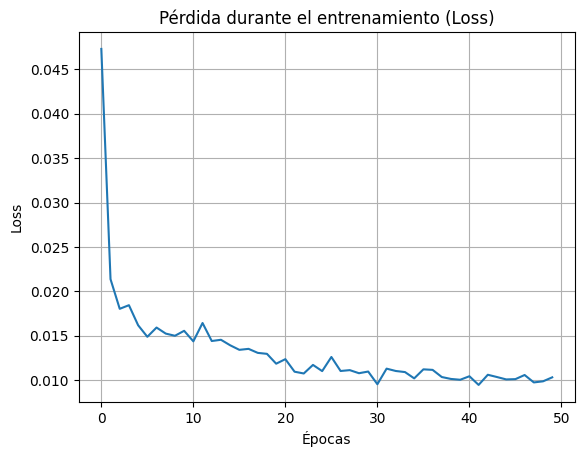

In [ ]:
# Construir el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model_lstm.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1)

# Graficar la pérdida durante el entrenamiento


plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
MAE: 15.31
RMSE: 18.85
MAPE: 24.68%
sMAPE: 21.12%


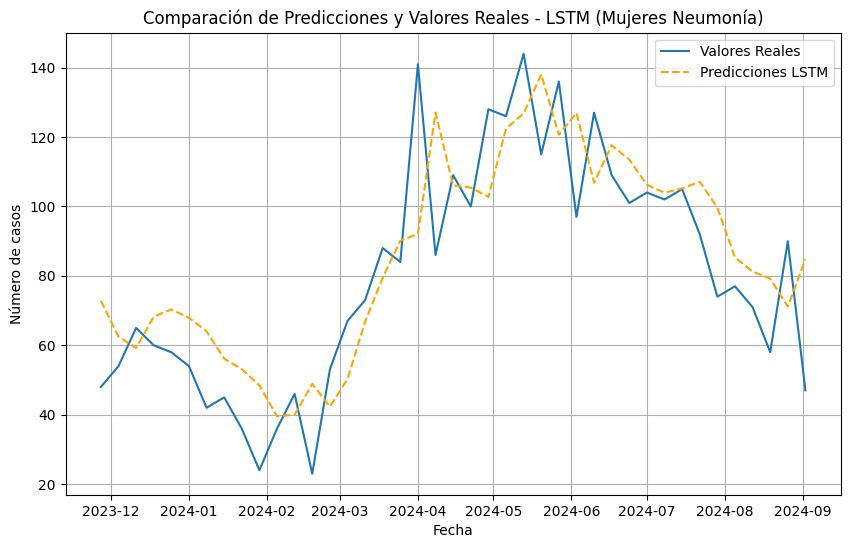

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_predict = model_lstm.predict(x_test)

# Desescalar las predicciones y los valores reales
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_lstm = mean_absolute_error(y_test[0], test_predict[:, 0])
rmse_lstm = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
mape_lstm = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100  # Convertir a porcentaje
smape_lstm = 100 * np.mean(2 * np.abs(y_test[0] - test_predict[:, 0]) / (np.abs(y_test[0]) + np.abs(test_predict[:, 0])))

# Imprimir métricas
print(f'MAE: {mae_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'sMAPE: {smape_lstm:.2f}%')

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(data_neumonia_mujeres.index[train_size + time_steps:], y_test[0], label='Valores Reales')
plt.plot(data_neumonia_mujeres.index[train_size + time_steps:], test_predict[:, 0], color='orange', linestyle='--', label='Predicciones LSTM')
plt.title("Comparación de Predicciones y Valores Reales - LSTM (Mujeres Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para LSTM
comparison_df_lstm_neumonia_mujeres = pd.DataFrame({
    'Fecha': data_neumonia_mujeres.index[train_size + time_steps:],
    'Valores Reales': y_test[0],
    'Predicciones LSTM': test_predict[:, 0]
})

# Mostrar el DataFrame comparativo
print(comparison_df_lstm_neumonia_mujeres)

        Fecha  Valores Reales  Predicciones LSTM
0  2023-11-27            48.0          72.846153
1  2023-12-04            54.0          62.508247
2  2023-12-11            65.0          59.206898
3  2023-12-18            60.0          68.264259
4  2023-12-25            58.0          70.316643
5  2024-01-01            54.0          67.936737
6  2024-01-08            42.0          64.032463
7  2024-01-15            45.0          56.118000
8  2024-01-22            36.0          53.130333
9  2024-01-29            24.0          48.441895
10 2024-02-05            36.0          39.549198
11 2024-02-12            46.0          39.984955
12 2024-02-19            23.0          48.877560
13 2024-02-26            53.0          42.322670
14 2024-03-04            67.0          50.260647
15 2024-03-11            73.0          66.803703
16 2024-03-18            88.0          79.474564
17 2024-03-25            84.0          90.145332
18 2024-04-01           141.0          92.072098
19 2024-04-08       

In [ ]:
# prompt: crea un dataframe con 8 fechas, separadas semanalmente. Que inicie el 2024-09-09

import pandas as pd

# Fecha inicial
start_date = pd.to_datetime('2024-09-09')

# Crear una lista de fechas con intervalos semanales
date_range = pd.date_range(start=start_date, periods=8, freq='7D')

# Crear un DataFrame con las fechas
dfechasfutu = pd.DataFrame({'fecha': date_range})

# Imprimir el DataFrame
dfechasfutu

,fecha
0,2024-09-09
1,2024-09-16
2,2024-09-23
3,2024-09-30
4,2024-10-07
5,2024-10-14
6,2024-10-21
7,2024-10-28


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
       fecha
0 2024-09-09
1 2024-09-16
2 2024-09-23
3 2024-09-30
4 2024-10-07
5 2024-10-14
6 2024-10-21
7 2024-10-28    Predicciones Futuras
0             70.251892
1             71.425621
2             75.785721
3             82.822983
4             87.169380
5             92.179153
6             96.521538
7            100.319138


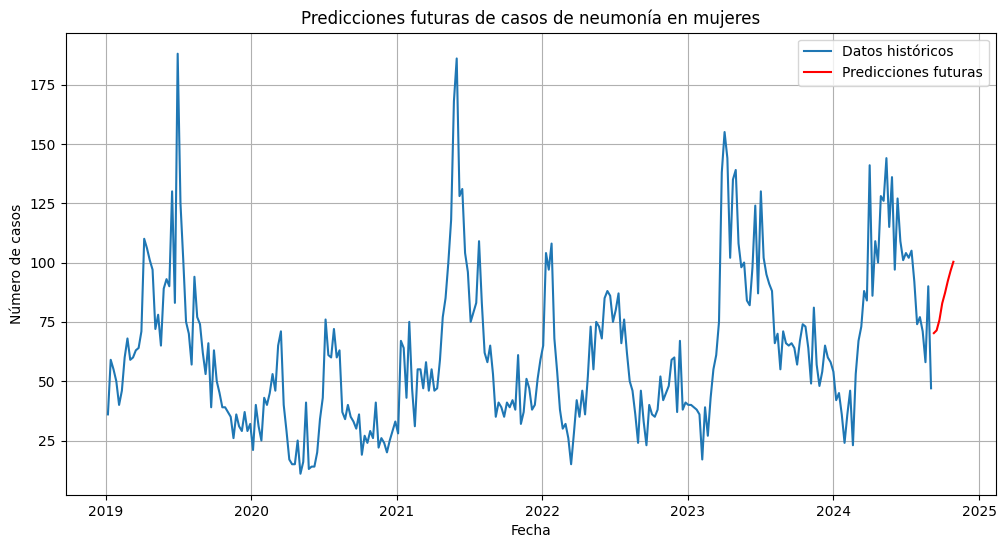

In [ ]:
# prompt: realiza 8 predicciones a futuro

# Extender las predicciones a futuro
future_steps = 8  # Número de pasos a futuro que se desean predecir

last_data_point = data_scaled[-time_steps:]  # Tomar los últimos time_steps datos
future_predictions = []

for _ in range(future_steps):
    next_prediction = model_lstm.predict(np.array([last_data_point]))
    future_predictions.append(next_prediction[0, 0])
    last_data_point = np.concatenate((last_data_point[1:], next_prediction))

# Desescalar las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


# Generar fechas futuras
last_date = data_neumonia_mujeres.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps)


# Crear DataFrame para las predicciones futuras
future_predictions_df = pd.DataFrame({
    #'Fecha': future_dates,
    'Predicciones Futuras': future_predictions[:, 0]
})

# Imprimir las predicciones futuras
print(dfechasfutu,future_predictions_df)

# Graficar las predicciones futuras junto con los datos históricos
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_mujeres.index, scaler.inverse_transform(data_scaled), label='Datos históricos')
plt.plot(dfechasfutu, future_predictions_df['Predicciones Futuras'], color='red', label='Predicciones futuras')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.title('Predicciones futuras de casos de neumonía en mujeres')
plt.legend()
plt.grid(True)
plt.show()

       fecha  Predicciones Futuras
0 2024-09-09             70.251892
1 2024-09-16             71.425621
2 2024-09-23             75.785721
3 2024-09-30             82.822983
4 2024-10-07             87.169380
5 2024-10-14             92.179153
6 2024-10-21             96.521538
7 2024-10-28            100.319138


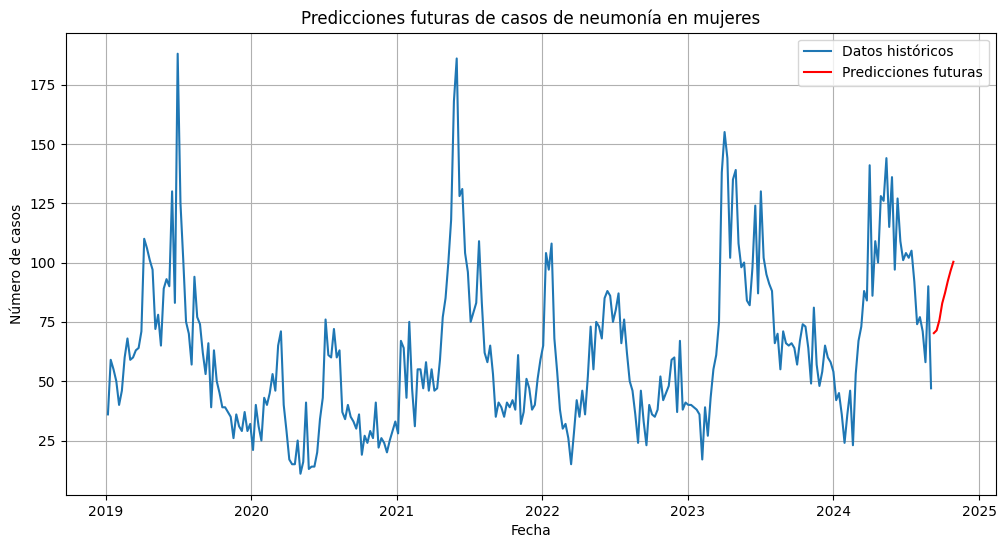

In [ ]:
# prompt: como unir 2 dataframes en uno

# Concatenar los DataFrames
result_df = pd.concat([dfechasfutu, future_predictions_df], axis=1)

# Imprimir el DataFrame resultante
print(result_df)

# Graficar las predicciones futuras junto con los datos históricos (actualizado)
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_mujeres.index, scaler.inverse_transform(data_scaled), label='Datos históricos')
plt.plot(result_df['fecha'], result_df['Predicciones Futuras'], color='red', label='Predicciones futuras')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.title('Predicciones futuras de casos de neumonía en mujeres')
plt.legend()
plt.grid(True)
plt.show()

MAE: 36.68
RMSE: 38.99
MAPE: 80.27%
sMAPE: 55.00%


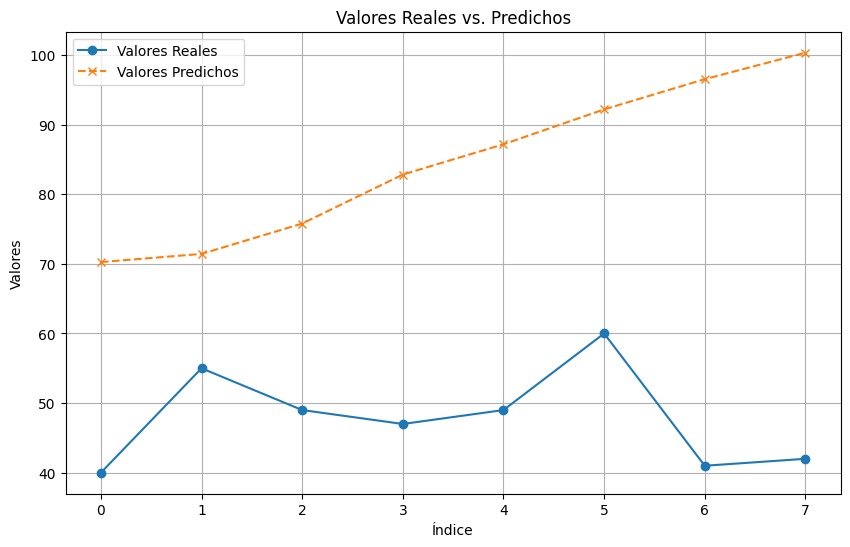

In [ ]:
# prompt: estos son los 8 valores reales, comparalos con los predichos, evalualos y graficalos:40, 55, 49, 47, 49, 60, 41, 42

# Valores reales proporcionados
real_values = [40, 55, 49, 47, 49, 60, 41, 42]

# Obtener las predicciones del modelo (asumiendo que future_predictions contiene las predicciones)
predicted_values = future_predictions_df['Predicciones Futuras'].values[:8].tolist()


# Evaluar las predicciones (Ejemplo usando MAE, RMSE y MAPE)
mae = mean_absolute_error(real_values, predicted_values)
rmse = np.sqrt(mean_squared_error(real_values, predicted_values))
mape = mean_absolute_percentage_error(real_values, predicted_values) * 100
smape = 100 * np.mean(2 * np.abs(np.array(real_values) - np.array(predicted_values)) / (np.abs(np.array(real_values)) + np.abs(np.array(predicted_values))))


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")

# Graficar los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Valores Reales', marker='o')
plt.plot(predicted_values, label='Valores Predichos', marker='x', linestyle='--')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores Reales vs. Predichos')
plt.legend()
plt.grid(True)
plt.show()